<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/neutrons-background-1/tutorials/Eljen-Background-Characterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/arpa-e-experiments/blob/neutrons-background-1/tutorials/Eljen-Background-Characterization.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# Eljen Detector Background Characterization

### Prequel - What's an Eljen detector ?

Eljen scintillator detectors work by converting ionizing radiation into visible light. Radiation excites molecules in the plastic; these de-excite and emit photons. The light is detected by a photomultiplier tube (PMT) or Silicon photomultiplier (SiPM), producing an electrical signal proportional to the energy deposited.

### Our Eljen Detectors 

In the lab, we have access to both a 2" and a 5" Eljen detector. Our goal in this notebook is to set up a precedure for chracterizing the background of one of these detectors from a "long"(~1 month) background measurments. Thus, we would like to characterize the probabilistic distribution of the background counts picked up by an Eljen detector and set up a protocolto use statistical tests to determine whether certain counts or bursts are background or events of significance in our experiments. 

In this first notebook, we will begin by analysising our **2" Eljen detector**.

In order to do so, we began by running the Eljen detectors in question throughout December 2024 and January 2025. We will now characterize this background---which will be useful for future analysis.


The data panel describing this backgroundmeasurement can be found here: https://lenr.mit.edu/data/load-panel.php?filename=eljen/eljen-2inch-long-term

In [2]:
# RUN THIS IF YOU ARE USING GOOGLE COLAB
import sys
import os
!git clone https://github.com/project-ida/arpa-e-experiments.git
sys.path.insert(0,'/content/arpa-e-experiments')
os.chdir('/content/arpa-e-experiments')

fatal: destination path 'arpa-e-experiments' already exists and is not an empty directory.


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/arpa-e-experiments'

In [1]:
# RUN THIS IF YOU ARE LOCAL. 
# It makes sure we can import helpers from libs which is one level up

import sys
import os

# Get the parent directory (one level up from the current directory)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the parent directory to sys.path
sys.path.insert(0, project_root)

In [2]:
# Libraries and helper functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import ipywidgets as widgets
from IPython.display import display

from IPython.display import Image
from IPython.display import Video
from IPython.display import HTML

# Use our custom helper functions
# - process_data
# - plot_panels
# - plot_panels_with_scatter
# - print_info
from libs.helpers import *

In [3]:
meta = {
    "descriptor" : "Eljen 2 inch 12-2024" # This will go into the title of all plots
}

## Step 1 - Data Collection

Let's begin by collecting raw data on the Eljen detectors of interest, ie the 2 inch detector to begin.  

We have collected long-term data on the neutron and gamma counts per sond picked up by our Eljen detectors, from December 14th 2024 00:01:01 to January 23rd, 2025 23:58:59. They are defined as dataframes, which we can manipulate using pandas, below.

In [4]:
neutron_df = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/eljen-2inch-long-term-1.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

gamma_df = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/eljen-2inch-long-term-4.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

In [22]:
# we will also start numbering our figures here for easier reference later in the notebook'
fig_counter = 0

## Step 2 - Visualizing Neutron and Gamma counts

Now that we have collected the raw data (i.e. electric signal history) that interests us, let us have a look at the measured neutron and gamma counts.

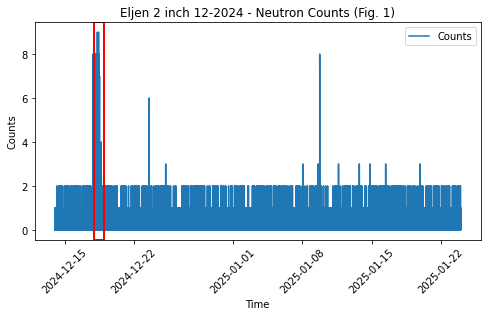

In [23]:
from matplotlib.patches import Rectangle

fig_counter += 1

plt.figure(figsize=(8, 4))
plt.plot(neutron_df['Counts'], label='Counts', zorder=1)
plt.xlabel('Time')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.title(f"{meta['descriptor']} - Neutron Counts (Fig. {fig_counter})")

ax = plt.gca()
start = pd.to_datetime('2024-12-18')
end   = start + pd.Timedelta(days=1)
ymin, ymax = ax.get_ylim()

rect = Rectangle((start, ymin),
                 end - start,
                 ymax - ymin,
                 linewidth=2,
                 edgecolor='red',
                 facecolor='none',
                 zorder=2)     

ax.add_patch(rect)

plt.legend()
plt.show()

We notice in the above plot a sharp neutron burst on 18 December (highlighted by the red square in Fig. 1). This spike coincides exactly with the introduction of a ²⁵²Cf source into the laboratory.

According to the LNHB decay tables, ²⁵²Cf disintegrates by α-emission almost exclusively to the ground state of ²⁴⁸Cm, and undergoes spontaneous fission with a branching ratio of $3.086 (8)%$ ([LNHB Cf-252 tables](http://www.lnhb.fr/nuclides/Cf-252_tables.pdf)). In each fission event, an average of $3.7675 (40)$ neutrons are emitted, yielding:

$$
n \;=\; 3.086\% \times 3.7675 \;\approx\; 0.11627\ \text{neutrons per decay}
\quad\longrightarrow\quad
11.627\ \text{neutrons per 100 decays}
$$

Furthermore, spontaneous fission of ²⁵²Cf is accompanied by prompt [γ-rays emitted within $10^{-14}$–$10^{-12}\,\text{s}$ of fragment formation](https://www.sciencedirect.com/science/article/pii/0375947475904820?utm). The average γ-multiplicity is approximately [10.3 photons per fission](https://link.springer.com/article/10.1007/BF02847802?utm), essentially simultaneous with neutron emission. Therefore, we expect to observe a coincident γ-burst in any detector with sufficient energy threshold and timing resolution, aligned with the neutron spike seen on 18 December.

This is indeed the case in the following plot.

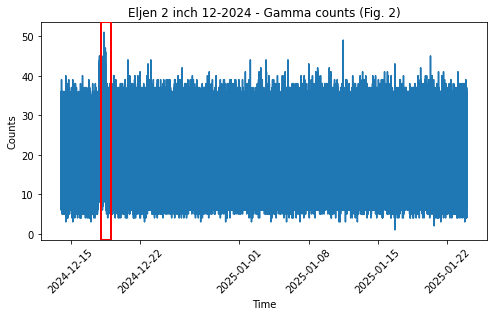

In [24]:
fig_counter +=1

plt.figure(figsize=(8, 4))
plt.plot(gamma_df['Counts'])
plt.xlabel('Time')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.title(f"{meta['descriptor']} - Gamma counts (Fig. {fig_counter})")

# highlight December 18th with a red square
ax = plt.gca()
start = pd.to_datetime('2024-12-18')      # adjust year if needed
end   = start + pd.Timedelta(days=1)
ymin, ymax = ax.get_ylim()
rect = Rectangle(
    (start, ymin),
    end - start,
    ymax - ymin,
    linewidth=2,
    edgecolor='red',
    facecolor='none', 
    zorder=10
)
ax.add_patch(rect)


plt.show()
# plt.savefig("all-gamma-counts-sec.png", dpi=600)

## Step 3 - Resampling data and Removing Neutron burst

The current data is taken about once per second. We'll now aggregate this data to present counts in 1 minute intervals.
This is an arbitrary choice, but will allow us to develop wom intuition about count binning. Indeed, larger time itnervals will necessarily include more counts, so it will be easier to distinguish by eye any significant events. This is not nessecarily the method we will keep for further analysis, but it remains useful in our intuition builing. In the future, we hope to remove the arbitrarity of binning all together (see later notebook explained in last section of this notebook).

Furthermore, we noticed above a neutron and gamma burst on December 18th. This corresponded to a time-period in which we brought a Cf-252 neutron source into the lab (ie the bursts that the detectors are picking up). Hence, in order to define a clear background time, we will start collecting data from December 19th.

So, in sum, the next step is to :


1. **Aggregate** the raw second-by-second counts into 1 minute bins.  
2. **Exclude** the burst period when the ²⁵²Cf source was in the lab (i.e. December 18), and begin our background analysis on December 19.

In [25]:
neutron_df_1_minute = neutron_df.resample('1min').sum()
gamma_df_1_minute = gamma_df.resample('1min').sum()

# Assuming neutron_df_1_minute has a datetime index
start_time = "2024-12-19 00:00:00"
end_time = "2025-01-23 23:59:00"

neutron_df_1_minute_background = neutron_df_1_minute.loc[start_time:end_time]
gamma_df_1_minute_background = gamma_df_1_minute[start_time:end_time]

## Step 4 - Analyzing the Bakground Counts

Now that we have excluded the time before and when the neutron source was introduced, let us have a closer look at our background neutron counts.

We will start by building a daily histogram of the background neutron counts per minute. Each line in the plot will represent one day’s worth of 1 minute bins, normalized to form a probability distribution. This lets us see how the shape of the count distribution varies from day to day.

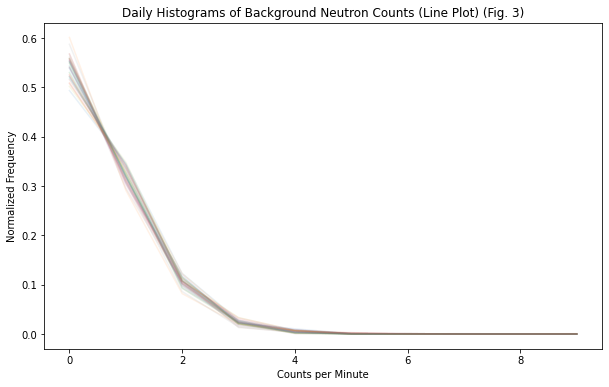

In [26]:
fig_counter +=1

# Ensure the index is datetime
neutron_df_1_minute_background.index = pd.to_datetime(neutron_df_1_minute_background.index)

# Group by day
grouped_by_day = neutron_df_1_minute_background.groupby(neutron_df_1_minute_background.index.date)

# Define bins for the histogram
bins = np.arange(neutron_df_1_minute_background["Counts"].min(),
                 neutron_df_1_minute_background["Counts"].max() + 1, 1)  # Use integer bins

# Plot all histograms as line plots
plt.figure(figsize=(10, 6))

for day, group in grouped_by_day:
    hist_values, bin_edges = np.histogram(group["Counts"], bins=bins, density=True)
    plt.plot(bin_edges[:-1], hist_values, alpha=0.1, label=str(day))

plt.xlabel("Counts per Minute")
plt.ylabel("Normalized Frequency")
plt.title(f"Daily Histograms of Background Neutron Counts (Line Plot) (Fig. {fig_counter})")
plt.show()

Quick comment on how to read this plot:

- Each line corresponds to one calendar day’s distribution of 1 minute neutron counts.
- Horizontal axis: number of counts detected in a 1 min bin.
- Vertical axis: normalized frequency (so that areas under each curve sum to 1).
- The shading/transparency helps you see where multiple days’ distributions overlap. Each color corresponds to the data from a different day.

In order to conduct a statistical analysis on these background counts, we need to have an idea of what qualifies as a "significant" deviation from background. This will be of interest when trying to determine whether or not we have detected an abnormal number of neutron counts.

## Side-step 4.1 Expected Poisson Distribution

Neutron background counts are typically modeled by a Poisson distribution because they arise from random, independent events which occur at a constant average rate over time. This aligns with the conditions under which the Poisson distribution is valid:

- Rare Events: Background neutrons are detected infrequently and individually—each detection is a discrete event.

- Statistical Independence: The arrival of one neutron does not affect the probability of another arriving.

- Constant Rate: Over short timescales (like 1-minute bins), the average background rate is approximately constant.

- Fixed Observation Interval: Counts are measured over uniform time intervals (ie counted over fixed 1 minute intervals).

Under these conditions, the number of neutrons detected in a fixed time interval follows a Poisson distribution with mean λ, where λ is the expected number of events (neutrons) per interval.

The standard deviation is thus $\sigma = \sqrt{λ}$

In the literature, we will typically consider that count is "significantly high" if it exceeds $\lambda + \sqrt{\lambda}\cdot Z$

where $Z = 3$ corresponds to a $3\sigma$ threshold (confidence level ~99.7%)

Let us now have a closer look at how close our background is to this Poisson distribution. 

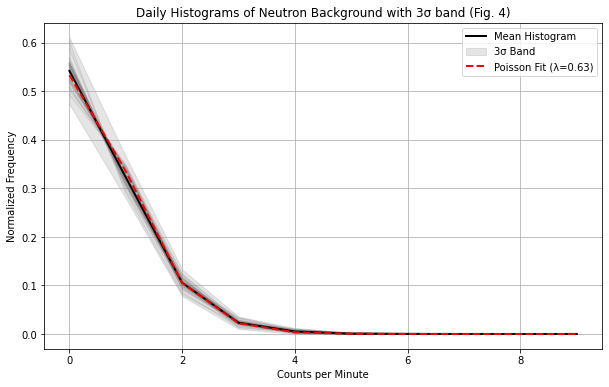

In [27]:
fig_counter += 1

histograms = []
for day, group in grouped_by_day:
    hist_values, bin_edges = np.histogram(group["Counts"], bins=bins, density=True)
    histograms.append(hist_values)

# Convert list to array and compute mean + std across days
histograms = np.array(histograms)
mean_histogram = np.mean(histograms, axis=0)
std_histogram = np.std(histograms, axis=0)

# Estimate Poisson background mean
lambda_ = neutron_df_1_minute_background["Counts"].mean()
threshold_3sigma = lambda_ + 3 * np.sqrt(lambda_)


# Poisson fit
k_values = bin_edges[:-1]  # Use bin centers (left edges)
poisson_pmf = stats.poisson.pmf(k_values, mu=lambda_)

# Normalize Poisson PMF for visual comparison
poisson_pmf_normalized = poisson_pmf / np.sum(poisson_pmf)  # Normalize manually
poisson_pmf_normalized *= np.sum(mean_histogram)  # Match total area to empirical hist

plt.figure(figsize=(10, 6))

# daily histograms
for hist_values in histograms:
    plt.plot(bin_edges[:-1], hist_values, alpha=0.2, color='gray')

# mean histogram
plt.plot(bin_edges[:-1], mean_histogram, color='black', linewidth=2, label='Mean Histogram')

# 3σ band
plt.fill_between(bin_edges[:-1],
                 np.maximum(mean_histogram - 3 * std_histogram, 0),
                 mean_histogram + 3 * std_histogram,
                 color='black', alpha=0.1, label='3σ Band')

# Poisson fit overlay
plt.plot(k_values, poisson_pmf_normalized, 'r--', linewidth=2, label=f'Poisson Fit (λ={lambda_:.2f})')

plt.xlabel("Counts per Minute")
plt.ylabel("Normalized Frequency")
plt.title(f"Daily Histograms of Neutron Background with 3σ band (Fig. {fig_counter})")
plt.legend()
plt.grid(True)
plt.show()


Let's take a step back to understand what we are looking at here.

The black line corresponds to the average distribution of neutron counts across all days.

The grey shaded area shows the spread of day-to-day variation, with upper and lower bounds at 3 standard deviations above and below the mean. Days that would lie outside this band would be statistically rare under normal conditions (probability < 0.3%). Hence, we may identify neutron bursts in future runs by looking at "outliers" of this grey shaded area.

The red dashed line corresponds to the theoretical distribution assuming that neutron counts follow a Poisson process. We plotted this normalized Poisson ditribution assuming the Poisson paramter $\lambda$ to me the mean of our background data i.e. $\lambda \approx 0.63$.

### Quantitative goodness-of-fit

In order to test more rigorously whether our background truly follows a Poisson process, we can perform a $χ^2$ (chi-square) goodness-of-fit test comparing the observed mean histogram to the expected Poisson probabilities:

1. Compute the test statistic  
   $$
     \chi^2 = \sum_{k} \frac{(O_k - E_k)^2}{E_k},
   $$
   where $O_k$ are the observed counts in bin $k$ (from the mean histogram) and $E_k = N_{\rm tot}\,P_{\rm Poisson}(k;\lambda)$.  
2. Under the null hypothesis (data ∼ Poisson\($\lambda)$, $\chi^2$ follows a $\chi^2$ distribution with $\text{Degrees of Freedom} = \text{number of bins} - 1 - 1$ (subtracting one for the estimated $\lambda$ and 1 for normalization).  
3. A large $p$-value $(p>0.05$) implies we cannot reject the Poisson hypothesis at the $5 \%$ level.

In the code below, we conduct this goodness of fit analysis and find a p value of $p = 0.9996229005$ so we cannot reject the null-hypothesis. Hence, for our purposes, we are in a good position to say that background follows a Poisson process.

In [28]:
# — Chi-square goodness-of-fit test —
# Aggregate observed counts across all days
O_counts = histograms.sum(axis=0)       # observed total counts per bin
N_tot = O_counts.sum()                         # total number of 1-min intervals

# Expected counts under Poisson(λ)
pk = stats.poisson.pmf(k_values, mu=lambda_)
E_counts = N_tot * pk

# Compute χ² statistic and p-value
chi2_stat = np.sum((O_counts - E_counts)**2 / E_counts)
dof = len(k_values) - 2  # degrees of freedon = bins minus 1 (normalization) minus 1 (λ estimated)
p_value = stats.chi2.sf(chi2_stat, dof)

print(f"Chi-square statistic: {chi2_stat:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p_value:.10f}")

if p_value > 0.05:
    print("Cannot reject Poisson(λ) at the 5% significance level.")
else:
    print("Data significantly deviate from Poisson(λ).")


Chi-square statistic: 0.66
Degrees of freedom: 8
p-value: 0.9996229005
Cannot reject Poisson(λ) at the 5% significance level.


## Side-Step 4.2 – Stability of the Background Rate and Normality of Daily Means

Furthermore, before trusting the aformentioned single global $\lambda$, we should check how much the daily average neutron count per minute varies over our measurement period, and whether those daily means themselves follow an approximately normal distribution (by the Central Limit Theorem, if $\lambda$ is truly constant).


Daily mean counts per minute: μ = 0.63, σ = 0.04


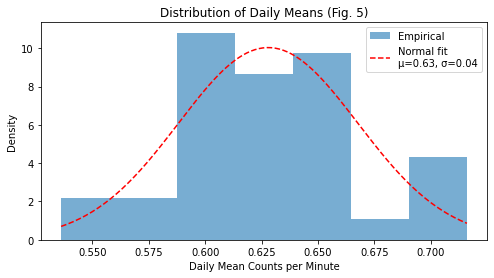

In [29]:
# 1. Compute daily means
daily_means = [group["Counts"].mean() for _, group in grouped_by_day]
days = list(grouped_by_day.groups.keys())

# 2. Summary statistics
mu_daily   = np.mean(daily_means)
sigma_daily = np.std(daily_means)
print(f"Daily mean counts per minute: μ = {mu_daily:.2f}, σ = {sigma_daily:.2f}")

# 3. Histogram of daily means with Normal fit overlay
plt.figure(figsize=(8, 4))
# histogram
vals, edges, _ = plt.hist(daily_means, bins='auto', density=True, alpha=0.6, label='Empirical')
# normal PDF
x = np.linspace(min(edges), max(edges), 200)
pdf = stats.norm.pdf(x, loc=mu_daily, scale=sigma_daily)
plt.plot(x, pdf, 'r--', label=f'Normal fit\nμ={mu_daily:.2f}, σ={sigma_daily:.2f}')
plt.xlabel('Daily Mean Counts per Minute')
plt.ylabel('Density')
plt.title(f'Distribution of Daily Means (Fig. {fig_counter+1})')
plt.legend()
plt.show()

## Goodness of fit check

The above plot does not shed enough light on how close our mean distribution is to a normal one. In order to determine the goodness of our fit, we may start with a graphical check: the QQ-plot. This plot sample quantiles vs theoretical normal quantiles; and deviations from the straight line highlight non-normality.

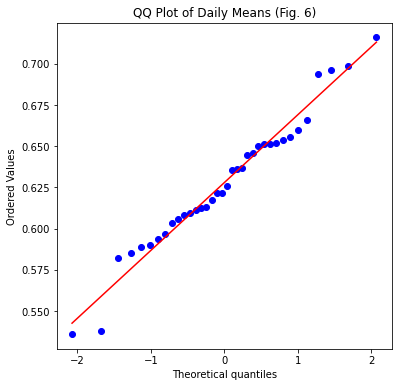

In [30]:
# 4. QQ-plot for normality check
plt.figure(figsize=(6, 6))
stats.probplot(daily_means, dist="norm", plot=plt)
plt.title(f'QQ Plot of Daily Means (Fig. {fig_counter+2})')
plt.show()

This, however, is not a "quantitative" measure of the goodness of our fit. For this, we will perform the Shapiro-Wilk test. 

The Shapiro–Wilk test computes a statistic  
$$
W \;=\; \frac{\bigl(\sum_{i=1}^n a_i\,x_{(i)}\bigr)^2}
                {\sum_{i=1}^n\bigl(x_i - \bar x\bigr)^2}\,,
$$  

where the $x_{(i)}$ are the ordered sample values, the $a_i$ are constants derived from the means and covariances of order statistics of a normal distribution, and $\bar x$ is the sample mean.  Under the null hypothesis that the data come from a normal distribution, $W$ is close to 1; values substantially below 1 indicate departure from normality.

In practice, we obtain from `scipy.stats.shapiro(daily_means)` both the test statistic $W$ and a $p$-value.  We then compare the $p$-value to our significance level (commonly $\alpha=0.05$):

- If $p > 0.05$, we **fail to reject** the null hypothesis: there is no strong evidence against normality.
- If $p \le 0.05$, we **reject** the null hypothesis: the daily means significantly deviate from a normal distribution.


In [31]:
# 5. Shapiro–Wilk test for normality
W, p_value = stats.shapiro(daily_means)
print(f"Shapiro–Wilk test: W = {W:.4f}, p-value = {p_value:.4f}")

if p_value > 0.05:
    print("Fail to reject H₀: data are consistent with a normal distribution")
else:
    print("Reject H₀: data significantly deviate from normality")

Shapiro–Wilk test: W = 0.9735, p-value = 0.5300
Fail to reject H₀: data are consistent with a normal distribution


By combining the visual Q–Q plot and the Shapiro–Wilk test, we obtain both qualitative and quantitative assurance that our daily means are well-approximated by a normal distribution—bolstering confidence in using a single global $\lambda$ for the background rate.  

So, it is a reasonable assumption to claim that our $\lambda$ is essentially constant over the January-December background collection period.

## Step 5 – From Statistical Characterization to an Actionable Protocol

### 1. Summary of Background Characterization  

Let's take a quick break to see what we have established so far:

**Poisson behavior confirmed.**  
- Chi-square test on the aggregated daily histograms yielded $\chi^2 = 0.66$, $dof = 8$, $p = 0.9996229005$, so we cannot reject that our long-term background follows $\mathrm{Poisson}(\lambda)$.  

**Mean and variance stability.**  
  - Global background rate  
    $$
      \lambda = 0.63 \;\text{counts/min},
      \quad \sigma_{\rm bkg} = \sqrt{\lambda} \approx 0.79.
    $$  
  - Daily‐mean distribution was nearly Gaussian with  
    $$\mu_{\rm daily}=0.63, \sigma_{\rm daily}=0.04$$

Together, these results show that over weeks of data our detector background is  

- Well described by a Poisson process with mean $\lambda$
- Highly stable

### 2. Protocol for Pre-Experiment “Quick Check”  

Let's now take a step back to remember the motivation for this notebook: background characterization of our Eljen detector. One of the main desired outcomes is thus a protocol to establish background for a new run using the Eljen detectors. In order to do this, we will propose the following:

Before each new experimental run, we should perform a short background measurement (e.g. few hours to 24 hours ideally) and then:

1. Compute the short-run mean  
   $$\hat\lambda_{\rm short} = \frac{\text{total counts in check}}{\text{duration in minutes}}$$
2. Compare to long-term λ 
3. Goodness‐of‐fit test (optional)
   - Build a quick histogram of the short-run counts and perform a χ² test against $\mathrm{Poisson}(\lambda)$.  
   - If $p > 0.05$, background is consistent; otherwise investigate.  
4. Decision  
   - If consistent: proceed with the planned experiment.  
   - If anomalous: pause and check for  
     - Instrument issues   
     - Environmental changes
     - Cosmic‐ray “weather” 

By embedding this “quick‐check” step into every experimental workflow, we ensure that our background conditions match the long‐term characterization before any experiment is conducted.

# Next Steps - Bin-Independent distributions.

In the notebook above, we chose arbitrary time-bins of 1 second and 1 minute. Howvere, ther Eljen detectors do not record counts per minute, but rather record individual waveforms and their timestamps with nano-second precision. Thus, it would be possible to implement a neutron background analysis method independent of binning.

We propose to work instead directly with inter-arrival times (deltas) between successive neutron/ gamma counts. This approach appears rather natural for a Poisson process, where the times ebtween events are exponentially ditributed. 

Let us propose a temporary outline for this method, which we will elaborate in a future notebook. 


### 1. Record the inter-arrival times

Let our raw timestamps be  
$$t_1, t_2, \dots, t_N$$  
(measured in seconds with our Eljen detector’s native nanosecond precision).  Define  
$$\Delta t_i = t_{i} - t_{i-1},\quad i=2,\dots,N.$$  
Because our detector’s resolution is $\Delta t_{\min} = 1\ \mathrm{ns}$ but the observed spacings are typically much larger, we can treat the data as effectively continuous.

### 2. Empirical cumulative distribution (CDF)

Instead of a histogram, we build the empirical CDF of the inter-arrival times:
$$
\widehat F(t)
\;=\;
\frac{1}{N-1}
\sum_{i=2}^{N}
\mathbf{1}\bigl(\Delta t_i \le t\bigr).
$$
Plotting $\widehat F(t)$ against $t$ gives the **cumulative spectrum**:
- On the horizontal axis: time $t$ (s)
- On the vertical axis: probability $P(\Delta t \le t)$

### 3. Comparison to the theoretical exponential CDF

For a homogeneous Poisson process with rate $\lambda$ (counts per second), the true inter-arrival distribution is  
$$
F_{\rm exp}(t) = 1 - e^{-\lambda\,t}.
$$  
We can overlay this on our empirical CDF:
1. Estimate $\lambda = 1 / \bar{\Delta t}$.  
2. Compute  
   $$
   F_{\rm exp}(t) = 1 - \exp\!\bigl(-t / \bar{\Delta t}\bigr).
   $$
3. Plot both curves on the same axes to visually assess agreement.


### 4. Quantitative goodness-of-fit

To go beyond the visual overlay, we can perform a **Kolmogorov–Smirnov (K–S) test** comparing
$$
\{\Delta t_i\}_{i=2}^N
$$
to the exponential distribution with parameter $\hat\lambda = 1/\bar\Delta t$.  In Python: